# Jan Izydorczyk
# Sprawozdanie 9

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import random
import scipy
import sys
%matplotlib notebook

print("Wersja Pythona:")
print (sys.version)
print(f"Wersja numpy: {np.__version__}")
print("Konfiguracja liczb zmiennoprzecinkowych")
print(sys.float_info)

f64 = np.float64
f32 = np.float32

Wersja Pythona:
3.9.4 (tags/v3.9.4:1f2e308, Apr  6 2021, 13:40:21) [MSC v.1928 64 bit (AMD64)]
Wersja numpy: 1.20.2
Konfiguracja liczb zmiennoprzecinkowych
sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


In [2]:
from scipy.linalg import lu_factor, lu_solve
from itertools import chain, product
from timeit import timeit
import pandas as pd
from mpmath import nstr, mpf

In [3]:
import networkx as nx
import graphviz as gv

# Zadanie 1

$$r = cAr$$

$$A_{u, v}=
    \begin{cases}
      \frac{1}{N_u}, & \text{jeżeli krawędź}\ (u, v) \text{ istnieje} \\
      0, & \text{wpp}
    \end{cases} $$

In [4]:
from itertools import combinations, groupby
def gnp_random_connected_graph(n, p=0.1):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = reversed(random_edge)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                if random.random() < 0.5:
                    e = reversed(e)
                G.add_edge(*e)
    return G

In [5]:
def gnp_random_strongly_connected_graph(n, p=0.2):
    s = set()
    while len(s) < n:      
        G = gnp_random_connected_graph(n, p)
        s = max(nx.strongly_connected_components(G), key=len)
    return G

In [6]:
G = gnp_random_strongly_connected_graph(10, p=0.1)

<IPython.core.display.Javascript object>


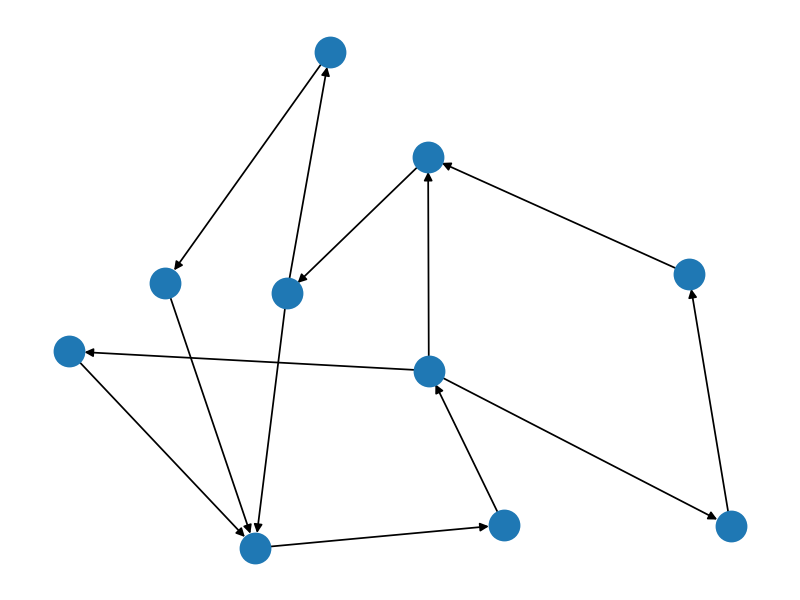

In [7]:
nx.draw(G)

In [8]:
def trans_matrix(G):
    n = len(G)
    M = np.zeros(shape=(n, n))
    for node in G.nodes:
        nbors = G[node]
        for nbor in nbors:
            M[node, nbor] = 1 / len(nbors)
            
    return M

In [9]:
M = trans_matrix(G)

In [10]:
def eig_(method):
    def wrapper(M, *args, x_0=None, epsilon=None, max_steps=None, epsilon_buff=None, **kwargs):
        
        def pred(x_t1, x_t, steps):
            nonlocal max_steps, epsilon
            res = True
            if epsilon is not None:
                if steps > 2e4:
                    print('Overflow')
                    print('----')
                    print(np.linalg.norm(x_t1 - x_t))
                    print('----')
                    return False
                res =  np.linalg.norm(x_t1 - x_t) > epsilon and np.linalg.norm(x_t1 + x_t) > epsilon
            elif max_steps is not None:
                res = steps < max_steps
            else:
                res = False
            if epsilon is not None and epsilon_buff is not None:
                epsilon_buff.append(np.mean(np.abs(x_t - x_t1)))
            return res
        if x_0 is None:
            x_0 = np.random.rand(M.shape[0], 1)
        else:
            x_0 = np.copy(x_0)
            
        return method(M, *args, x_0=x_0, epsilon=epsilon, max_steps=max_steps, pred=pred, **kwargs)
    return wrapper

In [11]:
@eig_
def power_method(M, x_0=None, epsilon=None, max_steps=None, pred=None):
    x_t = x_0
    steps = 0
    x = x_t + 2
    
    while pred(x_t, x, steps):
        steps += 1
        x = x_t
        x_t = M @ x_t
        idx = np.argmax(np.abs(x_t))
        max_val = x_t[idx, 0]
        x_t /= max_val
    return max_val, x_t / np.linalg.norm(x_t)

In [17]:
w, v = power_method(M.T, epsilon=1e-7)

In [18]:
np.sum(M, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [21]:
v /= np.sum(v)
print(w, v)


1.0 [[0.05555556]
 [0.05555555]
 [0.05555556]
 [0.05555555]
 [0.11111111]
 [0.11111111]
 [0.16666666]
 [0.05555555]
 [0.16666667]
 [0.16666667]]


In [15]:
w, v = np.linalg.eig(M)
w, v = w[0], np.abs(v[:, 0].reshape(-1, 1))

In [16]:
print(w, v)

(1.0000000000000002+0j) [[0.31622777]
 [0.31622777]
 [0.31622777]
 [0.31622777]
 [0.31622777]
 [0.31622777]
 [0.31622777]
 [0.31622777]
 [0.31622777]
 [0.31622777]]
